In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import random as rand
import math
import queue
import csv
from collections import OrderedDict
from IPython.display import clear_output
import csv
from heapq import merge
from sklearn import preprocessing
import gc
import os
from os import listdir
from os.path import isfile, join
import shutil
from configparser import ConfigParser
import ast
import sys
import re
from pathlib import Path
import pickle

from sklearn.datasets import make_circles, make_moons
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

rand.seed(37)

#from src.snapconfig import config
from src.snaputils import simulatespectra as sim
from src.snaptrain import process
from src.snaputils import reader

In [2]:
# Temporary config func. Original one in the project.
class config:
    """Define constants"""
    AAMass = OrderedDict([('A', 71.037114), ('C', 103.009185), ('D', 115.026943), ('E', 129.042593),
                          ('F', 147.068414), ('G', 57.021464), ('H', 137.058912), ('I', 113.084064),
                          ('K', 128.094963), ('L', 113.084064), ('M', 131.040485), ('N', 114.042927),
                          ('P', 97.052764), ('Q', 128.058578), ('R', 156.101111), ('S', 87.032028),
                          ('T', 101.047679), ('V', 99.068414), ('W', 186.079313), ('Y', 163.0633),
                          ('p', 79.97), ('o', 15.99), ('h', 0.98), ('c', 57.02), ('a', 42.01),
                          ('r', -17.03), ('y', 43.01), ('d', -18.01), ('t', 26.02)])

    ModMass = {"Oxidation": 15.994915, "CAM": 57.02146, "Carbamidomethyl": 57.02146, "ICAT_light": 227.12,
               "ICAT_heavy": 236.12, "AB_old_ICATd0": 442.20, "AB_old_ICATd8": 450.20, "Acetyl": 42.0106,
               "Deamidation": 0.9840, "Pyro-cmC": -17.026549, "Pyro-glu": -17.026549, "Pyro_glu": -18.010565,
               "Amide": -0.984016, "Phospho": 79.9663, "Methyl": 14.0157, "Carbamyl": 43.00581}

    ModCHAR = OrderedDict([("15.99", "o"), ("0.98", "h"), ("57.02", "c"), ("42.01", "a"), ("-17.03", "r"),
                           ("79.97", "p"), ("43.01", "y"), ("-18.01", "d"), ("26.02", "t")])
    # ModCHAR = {"15.99": "o", "0.98": "h", "57.02": "c", "42.01": "a", "-17.03": "r", "79.97": "p"}
    Ignore = ["U", "X"]
    Mods = [{"mod_char": "p", "aas": ["S", "T", "Y"]}
            # {"mod_char": "o", "aas": ["nt", "M"]}
           ]
    H2O = 18.015
    NH3 = 17.031
    PROTON = 1.00727647
    DEFAULT_PARAM_PATH = os.path.join(os.getcwd(), 'config.ini')
    PARAM_PATH = None
    l_config = None


    def get_config(section='input', key=None):
        """Read the configuration parameters and return a dictionary."""

        # If file path is given use it otherwise use default.
        file_path = config.PARAM_PATH if config.PARAM_PATH else config.DEFAULT_PARAM_PATH

        # Read config and convert each value to appropriate type.
        # Only for the first time.
        if not config.l_config:
            config.l_config = dict()
            config_ = ConfigParser()
            assert isinstance(file_path, str)
            config_.read(file_path)
            for section_ in config_.sections():
                config.l_config[section_] = dict()
                for key_ in config_[section_]:
                    try:
                        config.l_config[section_][key_] = ast.literal_eval(config_[section_][key_])
                    except (ValueError, SyntaxError):
                        config.l_config[section_][key_] = config_[section_][key_]

        if section and section in config.l_config:
            if key and key in config.l_config[section]:
                return config.l_config[section][key]
            return config.l_config[section]
        return config.l_config

In [3]:
def preprocess_msps(msp_dir, out_dir):
    in_path = Path(msp_dir)
    assert in_path.exists() and in_path.is_dir()
    
    msp_files = [join(msp_dir, f) for f in listdir(msp_dir) if
                 isfile(join(msp_dir, f)) and f.split('.')[-1] == 'msp']
    assert len(msp_files) > 0
    
    out_path = Path(out_dir)
    if out_path.exists() and out_path.is_dir():
        shutil.rmtree(out_path)
    out_path.mkdir()
    Path(join(out_path, 'spectra')).mkdir()
    Path(join(out_path, 'peptides')).mkdir()
        
    print('reading {} files'.format(len(msp_files)))
    
    count = 0
    max_peaks = max_moz = 0
    for species_id, msp_file in enumerate(msp_files):
        print('Reading: {}'.format(msp_file))
        
        f = open(msp_file, "r")
        lines = f.readlines()
        f.close()

        pep_list = []
        dataset = []
        label = []

        # FIXME: config should use only one get_config call.
        spec_size = config.get_config(section='input', key='spec_size')
        charge = config.get_config(section='input', key='charge')
        use_mods = config.get_config(section='input', key='use_mods')
        num_species = config.get_config(section='input', key='num_species')
        seq_len = config.get_config(section='ml', key='pep_seq_len')

        print('len of file: ' + str(len(lines)))
        limit = 200000
        pep = []
        spec = []
        pep_set = set()
        is_name = is_mw = is_num_peaks = False
        prev = 0
        i = 0
        while i < len(lines) and limit > 0:
            line = lines[i]
            i += 1
            if line.startswith('Name:'):
                name_groups = re.search(r"Name:\s(?P<pep>[a-zA-Z]+)/(?P<charge>\d+)"
                                        r"(?:_(?P<num_mods>\d+)(?P<mods>.*))?", line)
                if not name_groups:
                    continue
                    
                pep = name_groups['pep']
                if len(pep) + 1 > seq_len:
                    continue
                    
                l_charge = int(name_groups['charge'])
                num_mods = int(name_groups['num_mods'])

                is_name = True

            if is_name and line.startswith('MW:'):
                mass = float(re.findall(r"MW:\s([-+]?[0-9]*\.?[0-9]*)", line)[0])
                if round(mass) < spec_size:
                    is_mw = True
                    # limit = limit - 1
                else:
                    is_name = is_mw = is_num_peaks = False
                    continue

            if is_name and is_mw and line.startswith('Num peaks:'):
                num_peaks = int(re.findall(r"Num peaks:\s([0-9]*\.?[0-9]*)", line)[0])
                if num_peaks > max_peaks:
                    max_peaks = num_peaks

                spec = np.zeros(spec_size)
                while lines[i] != '\n':
                    mz_line = lines[i]
                    i += 1
                    mz_splits = mz_line.split('\t')
                    moz, intensity = float(mz_splits[0]), float(mz_splits[1])
                    if moz > max_moz:
                        max_moz = moz
                    spec[round(moz)] += round(intensity)

                # for k in range(1, charge + 1):
                #     spec[-k] = 0
                # spec[-l_charge] = 1000.0
                spec = np.clip(spec, None, 1000.0)
                # spec = preprocessing.scale(spec)

                is_num_peaks = True

            if is_name and is_mw and is_num_peaks:
                is_name = is_mw = is_num_peaks = False
                
                #pep = '{}{}{}'.format(charge, species_id, pep)

                """output the data to """
                spec_tensor = torch.tensor((np.asarray(spec) - 3.725) / 51.479, dtype=torch.float)
                
                torch.save(spec_tensor, 
                           join(out_dir, 'spectra', '{}-{}-{}-{}-{}.pt'
                                .format(count, species_id, mass, l_charge, int(num_mods > 0))))
                
                pep_file_name = '{}-{}-{}-{}-{}.pep'.format(count, species_id, mass, l_charge, int(num_mods > 0))
                    
                with open(join(out_path, 'peptides', pep_file_name), 'w+') as f:
                    f.write(pep)

                count = count + 1
                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new > prev:
                    clear_output(wait=True)
                    print(str(new) + '%')
                    prev = new

        print('max peaks: ' + str(max_peaks))
        print('count: ' + str(count))
        print('max moz: ' + str(max_moz))
#         return pep_list, dataset, label
#         tmp_pep_list, tmp_dataset, tmp_labels = read_msp(msp_file, species_id, decoy)
#         pep_list.extend(tmp_dataset)
#         dataset.extend(tmp_dataset)
#         label.extend(tmp_labels)

In [4]:
def preprocess_mgfs_back(mgf_dir, out_dir):
    in_path = Path(mgf_dir)
    assert in_path.exists() and in_path.is_dir()
    
    mgf_files = [join(mgf_dir, f) for f in listdir(mgf_dir) if
                 isfile(join(mgf_dir, f)) and f.split('.')[-1] == 'mgf']
    assert len(mgf_files) > 0
    
    out_path = Path(out_dir)
    if out_path.exists() and out_path.is_dir():
        shutil.rmtree(out_path)
        
    out_path.mkdir()
    Path(join(out_path, 'spectra')).mkdir()
    Path(join(out_path, 'peptides')).mkdir()
        
    print('reading {} files'.format(len(mgf_files)))
    
    ch = np.zeros(20)
    modified = 0
    unmodified = 0
    unique_pep_set = set()
    
    summ = 0
    sq_sum = 0
    N = 0
    
    tot_count = 0
    max_peaks = max_moz = 0
    for species_id, mgf_file in enumerate(mgf_files):
        print('Reading: {}'.format(mgf_file))
        
        f = open(mgf_file, "r")
        lines = f.readlines()
        f.close()
        
        count = lcount = 0

        pep_list = []
        dataset = []
        label = []
        
        mass_ign = 0
        pep_len_ign = 0
        dup_ign = 0

        # FIXME: config should use only one get_config call.
        spec_size = config.get_config(section='input', key='spec_size')
        charge = config.get_config(section='input', key='charge')
        use_mods = config.get_config(section='input', key='use_mods')
        num_species = config.get_config(section='input', key='num_species')
        seq_len = config.get_config(section='ml', key='pep_seq_len')

        print('len of file: ' + str(len(lines)))
        limit = 200000
        pep = []
        spec = []
        pep_set = set()
        is_name = is_mw = is_charge = False
        prev = 0
        i = 0
        while i < len(lines) and limit > 0:
            line = lines[i]
            i += 1

            if line.startswith('PEPMASS'):
                count += 1
                mass = float(re.findall(r"PEPMASS=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                if round(mass) < spec_size:
                    is_mw = True
                    # limit = limit - 1
                else:
                    is_name = is_mw = is_charge = False
                    mass_ign += 1
                    continue
            
            if is_mw and line.startswith('CHARGE'):
                l_charge = int(re.findall(r"CHARGE=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                is_charge = True
                
            if is_mw and is_charge and line.startswith("SEQ"):
                line = line.strip()
                pep_segs = re.findall(r"([A-Z]+)", line)[1:]
                num_mods = len(pep_segs) - 1 + (1 if line[-1] == ')' else 0)
                pep = ''.join(pep_segs)
                mods = re.findall(r"([A-Z]\([^\(\)]*\))", line)
                
                if len(pep) + 2 > seq_len:
                    pep_len_ign += 1
                    is_name = is_mw = is_charge = False
                    continue
                
                rtinsec = lines[i-2]
                rt = round(float(re.findall(r"RTINSECONDS=([-+]?[0-9]*\.?[0-9]*)", rtinsec)[0]))
                check_pep = line[4:] + str(l_charge) + "-" + str(rt)
                # check_pep = pep + str(l_charge)
                if check_pep in pep_set:
                    dup_ign += 1
                    is_mw = is_charge = is_name = False
                    continue
                else:
                    ch[l_charge] += 1
                    if num_mods > 0:
                        modified += 1
                    else:
                        unmodified += 1
                    if pep not in unique_pep_set:
                        unique_pep_set.add(pep)
                    pep_set.add(check_pep)
                    

                ind = [] # setting the precision to one decimal point.
                val = []
                #for ch_val in range(l_charge):
                #    ind.append(ch_val)
                #    val.append(1)
                    
                while 'END IONS' not in lines[i].upper():
                    if lines[i] == '\n':
                        continue
                    mz_line = lines[i]
                    i += 1
                    mz_splits = mz_line.split(' ')
                    moz, intensity = float(mz_splits[0]), float(mz_splits[1])
                    if moz > max_moz:
                        max_moz = moz
                    if 0 < round(moz) < spec_size:
                        # spec[round(moz*10)] += round(intensity)
                        ind.append(round(moz*10))
                        val.append(intensity)
                        
                        
                # for k in range(1, charge + 1):
                #     spec[-k] = 0
                # spec[-l_charge] = 1000.0
                
                ind = np.array(ind)
                val = np.clip(val, None, 10000.0)
                assert len(ind) == len(val)
                spec = np.array([ind, val])
                
                summ += sum(val)
                sq_sum += sum(s_val*s_val for s_val in val)
                N += 80000
                # spec = preprocessing.scale(spec)

                is_name = True

            if is_name and is_mw and is_charge:
                is_name = is_mw = is_charge = False
                
                #pep = '{}{}{}'.format(charge, species_id, pep)

                """output the data to """
                #spec_tensor = torch.tensor((np.asarray(spec) - 3.725) / 51.479, dtype=torch.float)
                # ind = torch.LongTensor([[0]*len(ind), ind])
                # val = torch.FloatTensor(val)
                # spec_tensor = torch.sparse.FloatTensor(ind, val, torch.Size([1, 80000]))
                
                # spec_tensor = torch.tensor(np.asarray(spec), dtype=torch.float)
                
#                 torch.save(spec_tensor, 
#                            join(out_dir, 'spectra', '{}-{}-{}-{}-{}.pt'
#                                 .format(tot_count, species_id, mass, l_charge, int(num_mods > 0))))
                
                np.save(join(out_dir, 'spectra', '{}-{}-{}-{}-{}.npy'
                             .format(tot_count, species_id, mass, l_charge, int(num_mods > 0))),
                       spec)
                
                pep_file_name = '{}-{}-{}-{}-{}.pep'.format(tot_count, species_id, mass, l_charge, int(num_mods > 0))
                    
                with open(join(out_dir, 'peptides', pep_file_name), 'w+') as f:
                    f.write(pep)

                lcount += 1
                tot_count += 1
                
                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new >= prev + 10:
                    #clear_output(wait=True)
                    print('count: ' + str(lcount))
                    print(str(new) + '%')
                    prev = new

        #print('max peaks: ' + str(max_peaks))
        print('In current file, read {} out of {}'.format(lcount, count))
        print("Ignored: large mass: {}, pep len: {}, dup: {}".format(mass_ign, pep_len_ign, dup_ign))
        print('overall running count: ' + str(tot_count))
        print('max moz: ' + str(max_moz))
#         return pep_list, dataset, label
#         tmp_pep_list, tmp_dataset, tmp_labels = read_msp(msp_file, species_id, decoy)
#         pep_list.extend(tmp_dataset)
#         dataset.extend(tmp_dataset)
#         label.extend(tmp_labels)
    print("Statistics:")
    print("Charge distribution:")
    print(ch)
    print("Modified:\t{}".format(modified))
    print("Unmodified:\t{}".format(unmodified))
    print("Unique Peptides:\t{}".format(len(unique_pep_set)))
    print("Sum: {}".format(summ))
    print("Sum-Squared: {}".format(sq_sum))
    print("N: {}".format(N))
    mean = summ / N
    print("mean: {}".format(mean))
    std = math.sqrt((sq_sum / N) - mean**2)
    print("std: {}".format(std))

In [5]:
def create_out_dir(dir_path, exist_ok=True):
    out_path = Path(dir_path)
    if out_path.exists() and out_path.is_dir():
        if not exist_ok:
            shutil.rmtree(out_path)
            out_path.mkdir()
    else:
        out_path.mkdir()
        
    Path(join(out_path, 'spectra')).mkdir()
    Path(join(out_path, 'peptides')).mkdir()

In [6]:
def verify_in_dir(dir_path, ext, ignore_list):
    in_path = Path(dir_path)
    assert in_path.exists() and in_path.is_dir()
    
    files = [join(dir_path, f) for f in listdir(dir_path) if
                 isfile(join(dir_path, f)) and not f.startswith('.') 
                 and f.split('.')[-1] == ext and f not in ignore_list]
    assert len(files) > 0
    return files

In [7]:
def isfloat(str_float):
    try:
        float(str_float)
        return True
    except ValueError: 
        return False

In [8]:
def mod_repl(match):
    lookup = str(round(float(match.group(0)), 2))
    return config.ModCHAR[lookup] if lookup in config.ModCHAR else ""

In [14]:
def preprocess_mgfs(mgf_dir, out_dir):
    
    mgf_files = verify_in_dir(mgf_dir, "mgf", [])
    create_out_dir(out_dir, exist_ok=False)
        
    print('reading {} files'.format(len(mgf_files)))
    
    spec_size = config.get_config(section='input', key='spec_size')
    charge = config.get_config(section='input', key='charge')
    use_mods = config.get_config(section='input', key='use_mods')
    num_species = config.get_config(section='input', key='num_species')
    seq_len = config.get_config(section='ml', key='pep_seq_len')
    
    ch = np.zeros(20)
    modified = 0
    unmodified = 0
    unique_pep_set = set()
    
    pep_dict = {}
    idx_spec_map = []
    pep_spec = []
    pep_idx = 0
    
    summ = np.zeros(spec_size)
    sq_sum = np.zeros(spec_size)
    N = 0
    
    tot_count = 0
    max_peaks = max_moz = 0
    for species_id, mgf_file in enumerate(mgf_files):
        print('Reading: {}'.format(mgf_file))
        
        f = open(mgf_file, "r")
        lines = f.readlines()
        f.close()
        
        count = lcount = 0
        
        pep_list = []
        dataset = []
        label = []
        
        mass_ign = 0
        pep_len_ign = 0
        dup_ign = 0

        print('len of file: ' + str(len(lines)))
        limit = 200000
        pep = []
        spec = []
        pep_set = set()
        is_name = is_mw = is_charge = False
        prev = 0
        i = 0
        while i < len(lines) and limit > 0:
            line = lines[i]
            i += 1

            if line.startswith('PEPMASS'):
                count += 1
                mass = float(re.findall(r"PEPMASS=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                if round(mass)*10 < spec_size:
                    is_mw = True
                    # limit = limit - 1
                else:
                    is_name = is_mw = is_charge = False
                    mass_ign += 1
                    continue
            
            if is_mw and line.startswith('CHARGE'):
                l_charge = int(re.findall(r"CHARGE=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                mass = (mass - config.PROTON) * l_charge
                is_charge = True
                
            if is_mw and is_charge and line.startswith("SEQ"):
                line = re.sub(r"[()]", "", line.strip()).split('=')[-1]
                mod_repl_rex = r'([-+]?\d*\.\d+|[-+]?\d+)'
                pep, num_mods = re.subn(mod_repl_rex, mod_repl, line)
                if pep[0].islower():
                    pep = pep[1] + pep[0] + pep[2:]
                #pep, num_mods = re.subn(mod_repl_rex, "", line)
                
                if len(pep) + 2 > seq_len:
                    pep_len_ign += 1
                    is_name = is_mw = is_charge = False
                    continue
                
                # rtinsec = lines[i-2]
                # rt = round(float(re.findall(r"RTINSECONDS=([-+]?[0-9]*\.?[0-9]*)", rtinsec)[0]))
                # check_pep = line[4:] + str(l_charge)#  + "-" + str(rt)
                # check_pep = pep + str(l_charge)
                sub_spec_count = 1
                pep_file_name = ''
                spec_file_name = ''
                
                ch[l_charge] += 1
                if num_mods > 0:
                    modified += 1
                else:
                    unmodified += 1

                if pep not in pep_dict:
                    pep_dict[pep] = pep_idx
                    idx_spec_map.append(sub_spec_count)
                    assert len(idx_spec_map) == len(pep_dict)
                    tot_count = pep_idx
                    pep_file_name = '{}.pep'.format(tot_count)
                    spec_file_name = '{}.{}-{}-{}-{}-{}.npy'.format(
                        tot_count, sub_spec_count, species_id, mass, l_charge, num_mods)
                    pep_spec.append([pep_file_name, [spec_file_name]])
                    pep_idx += 1
                else:
                    tot_count = pep_dict[pep]
                    sub_spec_count = idx_spec_map[tot_count] + 1
                    idx_spec_map[tot_count] = sub_spec_count
                    spec_file_name = '{}.{}-{}-{}-{}-{}.npy'.format(
                        tot_count, sub_spec_count, species_id, mass, l_charge, num_mods)
                    pep_spec[tot_count][1].append(spec_file_name)
                    
                        
                if pep not in unique_pep_set:
                    unique_pep_set.add(pep)
                    # pep_set.add(check_pep)
                    

                ind = [0] # reserving space for mass
                val = [0] # reserving space for mass
                
                for ch_val in range(l_charge):
                    ind.append(ch_val+1)
                    val.append(0)

                while not isfloat(re.split(' |\t|=', lines[i])[0]):
                    i += 1
                    
                while 'END IONS' not in lines[i].upper():
                    if lines[i] == '\n':
                        i += 1
                        continue
                    mz_line = lines[i]
                    i += 1
                    mz_splits = re.split(' |\t', mz_line)
                    moz, intensity = float(mz_splits[0]), float(mz_splits[1])
                    if moz > max_moz:
                        max_moz = moz
                    if 0 < round(moz*10) < spec_size:
                        # spec[round(moz*10)] += round(intensity)
                        if ind[-1] == moz*10:
                            val[-1] += intensity
                        else:
                            ind.append(round(moz*10))
                            val.append(intensity)
                        
                # for k in range(1, charge + 1):
                #     spec[-k] = 0
                # spec[-l_charge] = 1000.0
                
                # val = preprocessing.scale(val)
                
                # TODO: also try with clipping
                ind = np.array(ind)
                val = np.array(val)
                val = (val - np.amin(val)) / (np.amax(val) - np.amin(val))
                val[0] = mass
                for ch_val in range(l_charge):
                    val[ch_val+1] = 1
                assert len(ind) == len(val)
                spec = np.array([ind, val])
                
                summ[ind] += val
                sq_sum[ind] += val**2
                N += 1

                is_name = True

            if is_name and is_mw and is_charge:
                is_name = is_mw = is_charge = False
                
                #pep = '{}{}{}'.format(charge, species_id, pep)

                """output the data to """
                #spec_tensor = torch.tensor((np.asarray(spec) - 3.725) / 51.479, dtype=torch.float)
                # ind = torch.LongTensor([[0]*len(ind), ind])
                # val = torch.FloatTensor(val)
                # spec_tensor = torch.sparse.FloatTensor(ind, val, torch.Size([1, 80000]))
                
                # spec_tensor = torch.tensor(np.asarray(spec), dtype=torch.float)
                
#                 torch.save(spec_tensor, 
#                            join(out_dir, 'spectra', '{}-{}-{}-{}-{}.pt'
#                                 .format(tot_count, species_id, mass, l_charge, int(num_mods > 0))))
                
#                 np.save(join(out_dir, 'spectra', '{}.{}-{}-{}-{}-{}.npy'
#                              .format(tot_count, sub_spec_count, species_id, mass, l_charge, num_mods)),
#                        spec)
                
                np.save(join(out_dir, 'spectra', spec_file_name), spec)
                # sub_spec_count > 1 means more than one spectra for the same peptide 
                # therefore, no need to save the peptide again.
                if sub_spec_count == 1: # Write the peptide only the first time.
                    #pep_file_name = '{}.pep'.format(tot_count)
                    
                    with open(join(out_dir, 'peptides', pep_file_name), 'w+') as f:
                        f.write(pep)

                lcount += 1
                
                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new >= prev + 10:
                    #clear_output(wait=True)
                    print('count: ' + str(lcount))
                    print(str(new) + '%')
                    prev = new

        #print('max peaks: ' + str(max_peaks))
        print('In current file, read {} out of {}'.format(lcount, count))
        print("Ignored: large mass: {}, pep len: {}, dup: {}".format(mass_ign, pep_len_ign, dup_ign))
        print('overall running count: ' + str(tot_count))
        print('max moz: ' + str(max_moz))
#         return pep_list, dataset, label
#         tmp_pep_list, tmp_dataset, tmp_labels = read_msp(msp_file, species_id, decoy)
#         pep_list.extend(tmp_dataset)
#         dataset.extend(tmp_dataset)
#         label.extend(tmp_labels)

    # save the map. this will be used to generate masks for hard positive/negative mining during training.
    # np.save(join(out_dir, "idx_spec_map.npy"), idx_spec_map)
    with open(join(out_dir, 'pep_spec.pkl'), 'wb') as f:
        pickle.dump(pep_spec, f)
    
    print("Statistics:")
    print("Charge distribution:")
    print(ch)
    print("Modified:\t{}".format(modified))
    print("Unmodified:\t{}".format(unmodified))
    print("Unique Peptides:\t{}".format(len(unique_pep_set)))
    print("Sum: {}".format(summ))
    print("Sum-Squared: {}".format(sq_sum))
    print("N: {}".format(N))
    means = summ / N
    print("mean: {}".format(means))
    stds = np.sqrt((sq_sum / N) - means**2)
    stds[stds < 0.0000001] = float("inf")
    print("std: {}".format(stds))
    np.save(join(out_dir, 'means.npy'), means)
    np.save(join(out_dir, 'stds.npy'), stds)

In [15]:
# msp_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/msp-labeled/"
# in_tensor_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/train_lstm/"

in_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/"
in_tensor_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/train-ready/train_lstm_mods_mass_hcd_all/"

In [16]:
# transformer = transforms.Normalize(mean=[3.725], std=[51.479])
preprocess_mgfs(in_dir, in_tensor_dir)

reading 18 files
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/cptac2_mouse_hcd_itraq_phospho_selected.mgf
len of file: 281657
count: 115
10%
count: 217
20%
count: 337
30%
count: 433
40%
count: 541
50%
count: 664
60%
count: 783
70%
count: 902
80%
count: 1032
90%
In current file, read 1134 out of 1134
Ignored: large mass: 0, pep len: 0, dup: 0
overall running count: 1000
max moz: 4203.8618
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/human_synthetic_hcd_selected.mgf
len of file: 213341830
count: 67747
10%
count: 139376
20%
count: 210413
30%
count: 281467
40%
count: 348744
50%
count: 417376
60%
count: 486828
70%
count: 556234
80%
count: 626454
90%
In current file, read 696341 out of 696341
Ignored: large mass: 0, pep len: 0, dup: 0
overall running count: 204911
max moz: 4203.8618
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/cptac2_mouse_hcd_selected.mgf
len of file: 4170040
count: 1655
10%
coun

In [49]:
def preprocess_mgf_mods(mgf_dir):
    
    mgf_files = verify_in_dir(mgf_dir, "mgf")
        
    print('reading {} files'.format(len(mgf_files)))
    
    mod_counters = np.zeros(20)
    mod_type_counter_dict = {}
    n_mods = []
    i_mods = []
    c_mods = []
    modified = unmodified = 0
    
    mass_ign = pep_len_ign = 0
    
    for species_id, mgf_file in enumerate(mgf_files):
        print('Reading: {}'.format(mgf_file))
        
        f = open(mgf_file, "r")
        lines = f.readlines()
        f.close()
        
        count = lcount = 0

        # FIXME: config should use only one get_config call.
        seq_len = config.get_config(section='ml', key='pep_seq_len')
        spec_size = config.get_config(section='input', key='spec_size')

        print('len of file: ' + str(len(lines)))
        prev = 0
        i = 0
        while i < len(lines):
            line = lines[i]
            i += 1

            if line.startswith('PEPMASS'):
                count += 1
                mass = float(re.findall(r"PEPMASS=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                if not round(mass)*10 < spec_size:
                    mass_ign += 1
                    continue
                
            if line.startswith("SEQ"):
                line = re.sub(r"[()]", "", line.strip())
                pep_segs = re.findall(r"([A-Z]+)", line)[1:]
                pep = ''.join(pep_segs)
                #mods = re.findall(r"([A-Z]\([^\(\)]*\))", line)
                
                
                rex = r"([A-Z]?)([-+]?\d*\.\d+|\d+)([A-Z]?)"
                mods = re.findall(rex, line)
                num_mods = len(mods)
                
                if len(pep) + num_mods > seq_len:
                    pep_len_ign += 1
                    continue
                
                if num_mods <= len(mod_counters):
                    mod_counters[num_mods] += 1
                    
                if num_mods > 0:
                    modified += 1
                else:
                    unmodified += 1
                    
                for a in mods:
                    mass = round(float(a[1]), 2)
                    pre = a[0]
                    post = a[2]
                    if mass in mod_type_counter_dict:
                        mod_type_counter_dict[mass]["count"] += 1
                        if pre in mod_type_counter_dict[mass]:
                            mod_type_counter_dict[mass][pre] += 1
                        else:
                            mod_type_counter_dict[mass][pre] = 1
                    else:
                        mod_type_counter_dict[mass] = {"count":1, pre:1}
                    
                    if not a[0]:
                        n_mods.append(a)
                    elif not a[2]:
                        c_mods.append(a)
                    elif a[0] and a[1] and a[2]:
                        i_mods.append(a)
                    else:
                        print("Invalid mod")
                
                lcount += 1
                
                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new >= prev + 10:
                    #clear_output(wait=True)
                    print('count: ' + str(lcount))
                    print(str(new) + '%')
                    prev = new

        #print('max peaks: ' + str(max_peaks))
        print('In current file, read {} out of {}'.format(lcount, count))
    
    print("Statistics:")
    print("Modified:\t{}".format(modified))
    print("Unmodified:\t{}".format(unmodified))
    print("Num mod distribution:")
    print(mod_counters)
    print("Mod types:")
    print("{} types of mods found".format(len(mod_type_counter_dict)))
    print("Distribution:")
    print(mod_type_counter_dict)
    print("Number of N mods: {}".format(len(n_mods)))
    print("Number of C mods: {}".format(len(c_mods)))
    print("Number of I mods: {}".format(len(i_mods)))

In [50]:
in_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/"
preprocess_mgf_mods(in_dir)

reading 10 files
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/cptac2_mouse_hcd_itraq_phospho_selected.mgf
len of file: 281657
count: 116
10%
count: 218
20%
count: 338
30%
count: 434
40%
count: 542
50%
count: 665
60%
count: 784
70%
count: 903
80%
count: 1033
90%
In current file, read 1134 out of 1134
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/human_synthetic_hcd_selected.mgf
len of file: 213341830
count: 67748
10%
count: 139377
20%
count: 210414
30%
count: 281468
40%
count: 348745
50%
count: 417377
60%
count: 486829
70%
count: 556235
80%
count: 626455
90%
In current file, read 696341 out of 696341
Reading: /disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/mgfs-hcd/cptac2_mouse_hcd_selected.mgf
len of file: 4170040
count: 1656
10%
count: 3446
20%
count: 5287
30%
count: 7043
40%
count: 8900
50%
count: 10688
60%
count: 12455
70%
count: 14259
80%
count: 15905
90%
In current file, read 17830 out of 17830
Reading: /dis

## Statistics  
#### Modified:	1259406  
#### Unmodified:	2422940  
### Num mod distribution:  
[2.422940e+06 1.023623e+06 1.836600e+05 3.832100e+04 9.358000e+03  
 3.060000e+03 8.790000e+02 3.250000e+02 1.290000e+02 4.000000e+01  
 8.000000e+00 3.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]  
### Mod types:  
6 types of mods found  
### Distribution:  
{15.99: 290045, 0.98: 396500, 57.02: 640177, 42.01: 82730, 43.01: 123561, -17.03: 34679}  
{15.99: {'count': 290045, 'M': 279077, '': 10968}, 0.98: {'count': 396500, 'N': 234278, 'Q': 153930, '': 8292}, 57.02: {'count': 640177, 'C': 615747, '': 24430}, 42.01: {'count': 82730, '': 82730}, 43.01: {'count': 123561, '': 123561}, -17.03: {'count': 34679, '': 34679}}  
{15.99: {'count': 344652, 'M': 326428, '': 18224}, 0.98: {'count': 396500, 'N': 234278, 'Q': 153930, '': 8292}, 57.02: {'count': 745790, 'C': 711468, '': 34322}, 42.01: {'count': 86484, '': 86484}, 0.01: {'count': 702, '': 702}, -18.01: {'count': 18, '': 18}, -17.03: {'count': 34756, '': 34756}, 43.01: {'count': 123561, '': 123561}}  
#### Number of N mods: 284660  
#### Number of C mods: 4734  
#### Number of I mods: 1278298  

In [ ]:
mean = 325447965576.6338 / 25019920000
print("mean: {}".format(mean))
std = math.sqrt((2885406787428155.0 / 25019920000) - mean**2)
print(std)

In [ ]:
class LabeledSpectra(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dir_path, filt, test=False):
        'Initialization'
        
        self.aas         = ['_PAD'] + list(config.AAMass.keys())
        self.aa2idx      = {a:i for i, a in enumerate(self.aas)}
        self.idx2aa      = {i:a for i, a in enumerate(self.aas)}
        
        self.spec_path   = join(dir_path, 'spectra')
        self.pep_path    = join(dir_path, 'peptides')
        self.charge      = filt['charge'] if 'charge' in filt else config.get_config(section='input', key='charge')
        self.num_species = config.get_config(section='input', key='num_species')
        # self.vocab_size  = len(self.aa2idx) + self.charge + self.num_species + 1
        self.vocab_size  = round(max(config.AAMass.values())) + 1
        self.seq_len     = config.get_config(section='ml', key='pep_seq_len')
        self.modified    = filt['modified'] if 'modified' in filt else False
        self.test_size   = config.get_config(section='ml', key='test_size')
        self.test        = test
        
        self.file_names  = []
        for file in listdir(self.spec_path):
            if self.apply_filter(file):
                self.file_names.append(file)
        
        print('dataset size: {}'.format(len(self.file_names)))        
        
        self.train_files, self.test_files = train_test_split(
            self.file_names, test_size = self.test_size, random_state = rand.randint(0, 1000), shuffle=True)
        
        if self.test:
            print('test size: {}'.format(len(self.test_files)))
        else:
            print('train size: {}'.format(len(self.train_files)))
        
    def __len__(self):
        'Denotes the total number of samples'
        if self.test:
            return len(self.test_files)
        else:
            return len(self.train_files)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = ''
        # Select sample
        if self.test:
            file_name = self.test_files[index]
        else:
            file_name = self.train_files[index]
            
        spec_file_name = join(self.spec_path, file_name)
        pep_file_name  = join(self.pep_path, file_name.replace('.pt', '.pep'))
        
        # Load data and get label
        spec_torch = torch.load(spec_file_name)
        
        # Load peptide and convert to idx array
        f = open(pep_file_name, "r")
        pep = f.readlines()[0].strip()
        f.close()
        
        pepl = np.zeros(len(pep))
        file_parts = re.search(r"(\d+)-(\d+)-(\d+.\d+)-(\d)-(0|1).pt", file_name)
        pepl[0] = int(file_parts[4]) + len(self.aas)  # coded value of charge
        pepl[1] = int(file_parts[2]) + self.charge + 1 + len(self.aas) # coded value of specie id
        
        # for i in range(2, len(pep)):
        #     pepl[i] = self.aa2idx[pep[i]]
        for i, aa in enumerate(pep[2:]):
            pepl[i + 2] = self.aa2idx[aa]
            # pepl[i + 2] = round(config.AAMass[aa])
        
        pepl = self.pad_left(pepl, self.seq_len)
        pep_torch = torch.tensor(pepl, dtype=torch.long)
        
        return [spec_torch, pep_torch]
    
    def apply_filter(self, file_name):
        file_parts = re.search(r"(\d+)-(\d+)-(\d+.\d+)-(\d)-(0|1).pt", file_name)
        charge = int(file_parts[4])
        modified = bool(int(file_parts[5]))
        
        if ((self.charge == 0 or charge <= self.charge)
            and (self.modified or self.modified == modified)):
            return True
        
        return False
    
    def pad_left(self, arr, size):
        out = np.zeros(size)
        out[-len(arr):] = arr
        return out

In [ ]:
# data_mean = np.mean(dataset)
# data_std = np.std(dataset)

In [ ]:
# batch_size = config.get_config(section='ml', key='batch_size')
batch_size = 256
charge = config.get_config(section='input', key='charge')
use_mods = config.get_config(section='input', key='use_mods')
filt = {'charge':charge, 'modified':use_mods}


train_dataset = LabeledSpectra(in_tensor_dir, filt, test=False)
test_dataset = LabeledSpectra(in_tensor_dir, filt, test=True)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=8)

In [ ]:
do_learn = True
save_frequency = 2
lr = 0.0001
num_epochs = 200
weight_decay = 0.0001
margin = 0.2
vocab_size = train_dataset.vocab_size
#torch.manual_seed(0)
#torch.cuda.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda')

In [ ]:
#train_loader = torch.load('train_loader.pt')
#test_loader = torch.load('test_loader.pt')

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, output_size=512, embedding_dim=512, hidden_lstm_dim=1024, lstm_layers=2, drop_prob=0.5):
        super(Net, self).__init__()
        
        self.spec_size = config.get_config(section='input', key='spec_size')
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.hidden_lstm_dim = hidden_lstm_dim
        self.embedding_dim = embedding_dim
        self.searching = False
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_lstm_dim, self.lstm_layers, 
                            dropout=drop_prob, batch_first=True, bidirectional=True)
        
        self.linear1_1 = nn.Linear(self.spec_size, 1024)
        self.linear1_2 = nn.Linear(1024, 512)
        self.linear1_3 = nn.Linear(512, 256)
        
        self.linear2_1 = nn.Linear(2048, 1024)
        self.linear2_2 = nn.Linear(1024, 512)
        self.linear2_3 = nn.Linear(512, 256)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        #self.dropout3 = nn.Dropout(0.3)
        
    def forward(self, data, hidden):
        specs = data[0]
        peps = data[1]
        # print(peps.type())
        # print('Input to the model size: {}'.format(specs.size()))
        # print('Input to the model size: {}'.format(peps.size()))
        # peps = peps.unsqueeze(-1).float()
        # print(peps.type())
        
        embeds = self.embedding(peps)
        lstm_out, hidden = self.lstm(embeds, hidden)
        # print(lstm_out.size())
        lstm_out = lstm_out[:, -1, :]
        # print(lstm_out.size())
        #lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_lstm_dim * 2)
        out = self.dropout2(lstm_out)
        
        out = self.linear2_1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.linear2_2(out)
        out = F.relu(out)
        
        # out = out.view(batch_size, peps.size()[1], 512)
        # out = out[:,-1,:]
        out_pep = F.normalize(out)
        
        out = self.linear1_1(specs.view(-1, self.spec_size))
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.linear1_2(out)
        out = F.relu(out)
        out_spec = F.normalize(out)
        
        res = out_spec, out_pep, hidden
        return res
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_().to(device),
                      weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_().to(device))
        return hidden
    
    def name(self):
        return "Net"

In [ ]:
#hinge = torch.nn.HingeEmbeddingLoss()
triplet_loss = nn.TripletMarginLoss(margin=margin, p=2, reduction='sum')
l2_squared = nn.MSELoss(reduction='none')
pdist = nn.PairwiseDistance(p=2)
zero_tensor = torch.tensor(0.).to(device)
clip = 5

In [ ]:
def train(model, device, train_loader, epoch, optimizer):
    model.train()
    h = model.init_hidden(batch_size)
    
    accurate_labels = 0
    all_labels = 0
    for (batch_idx, data) in enumerate(train_loader):
        h = tuple([e.data for e in h])
        data[0], data[1] = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        Q, P, h = model(data, h)
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        """Mine the hardest triplets. Get rid of N.""" 
        QxQ = process.pairwise_distances(Q)    # calculate distance matrix for spectra
        PxP = process.pairwise_distances(P)    # calculate distance matrix for peptides
        QxP_ = process.pairwise_distances(Q, P) # calculate distance matrix for spectra-peptides
        
        # Set the diagonal of all distance matrices to inf so we don't get self as the closest negative.
        QxQ.fill_diagonal_(float("inf"))
        PxP.fill_diagonal_(float("inf"))
        QxP = QxP_.clone()
        QxP.fill_diagonal_(float("inf"))
        
        #print(QP.argmin(1)[:100])
        
#         pos = torch.sum(l2_squared(Q, P), dim=1) + margin
        
#         QxQ_min = QxQ.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest spectrum for each spectrum
#         PxP_min = PxP.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest peptide for each peptide
#         QxP_min = QxP.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest peptide for each spectrum
#         PxQ_min = QxP.gather(0, torch.randint(len(Q), (len(Q),), device=device).view(1,-1))             # farthest spectrum for each peptide
        
        QxQ_min = QxQ.min(1).values              # nearest spectrum for each spectrum
        PxP_min = PxP.min(1).values              # nearest peptide for each peptide
        QxP_min = QxP.min(1).values              # nearest peptide for each spectrum
        PxQ_min = QxP.min(0).values              # nearest spectrum for each peptide
        
        #neg = QxQ_min + PxP_min + QxP_min + PxQ_min
        
#         divider = torch.tensor(float(len(pos)))
#         loss = torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider
        
        #divider = torch.sum(pos - neg > 0)
        #loss = torch.sum(torch.max(pos - neg, zero_tensor)) / divider
        
        QxQ_min = Q[QxQ.min(1).indices]              # nearest spectrum for each spectrum
        PxP_min = P[PxP.min(1).indices]              # nearest peptide for each peptide
        QxP_min = P[QxP.min(1).indices]              # nearest peptide for each spectrum
        PxQ_min = Q[QxP.min(0).indices]              # nearest spectrum for each peptide
        loss = triplet_loss(Q, P, QxQ_min)           # spectrum-spectrum negatives
        loss += triplet_loss(Q, P, QxP_min)          # spectrum-peptide negatives
        loss += triplet_loss(P, Q, PxP_min)          # peptide-peptide negatives
        loss += triplet_loss(P, Q, PxQ_min)          # peptide-spectrum negatives
        
        loss = loss / 4
                
        loss.backward()
            
        optimizer.step()
        
        seq = torch.arange(0, len(Q), step=1, device=device, requires_grad=False)
        accurate_labels = accurate_labels + torch.sum(QxP_.argmin(1) == seq) # use QP_ since it doesn't have diag set to zero
        
        all_labels = all_labels + len(Q)  
    
    accuracy = 100. * float(accurate_labels) / all_labels
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    print('Epoch: ' + str(epoch))
    print('Train accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
    

In [ ]:
def test(model, device, test_loader):
    model.eval()
    
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        h = model.init_hidden(batch_size)
        
        for (batch_idx, data) in enumerate(test_loader):
            h = tuple([e.data for e in h])
            data[0], data[1] = data[0].to(device), data[1].to(device)
        
            optimizer.zero_grad()
            
            Q, P, h = model(data, h)
            
            """Mine the hardest triplets. Get rid of N.""" 
            QxQ = process.pairwise_distances(Q)    # calculate distance matrix for spectra
            PxP = process.pairwise_distances(P)    # calculate distance matrix for peptides
            QxP_ = process.pairwise_distances(Q, P) # calculate distance matrix for spectra-peptides

            # Set the diagonal of all distance matrices to inf so we don't get self as the closest negative.
            QxQ.fill_diagonal_(float("inf"))
            PxP.fill_diagonal_(float("inf"))
            QxP = QxP_.clone()    # clone to measure accuracy. can be done in a better way.
            QxP.fill_diagonal_(float("inf"))

            #print(QP.argmin(1)[:100])

            pos = 4 * (torch.sum(l2_squared(Q, P), dim=1) + margin)

            QxQ_min = QxQ.min(1).values              # farthest spectrum for each spectrum
            PxP_min = PxP.min(1).values              # farthest peptide for each peptide
            QxP_min = QxP.min(1).values              # farthest peptide for each spectrum
            PxQ_min = QxP.min(0).values              # farthest spectrum for each peptide

            #neg = QxQ_min + PxP_min + QxP_min + PxQ_min
        
#             divider = torch.tensor(float(len(pos)))
#             loss = torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider

            QxQ_min = Q[QxQ.min(1).indices]              # nearest spectrum for each spectrum
            PxP_min = P[PxP.min(1).indices]              # nearest peptide for each peptide
            QxP_min = P[QxP.min(1).indices]              # nearest peptide for each spectrum
            PxQ_min = Q[QxP.min(0).indices]              # nearest spectrum for each peptide
            loss = triplet_loss(Q, P, QxQ_min)     # spectrum-spectrum negatives
            loss += triplet_loss(Q, P, QxP_min)    # spectrum-peptide negatives
            loss += triplet_loss(P, Q, PxP_min)    # peptide-peptide negatives
            loss += triplet_loss(P, Q, PxQ_min)    # peptide-spectrum negatives
            
            loss = loss / 4

            #divider = torch.tensor(float(len(pos)))
            #divider = torch.sum(pos - neg > 0)
            #loss = torch.sum(torch.max(pos - neg, zero_tensor)) / divider
            
#             loss =  torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider
            
            seq = torch.arange(0, len(Q), step=1, device=device, requires_grad=False)
            accurate_labels = accurate_labels + torch.sum(QxP_.argmin(1) == seq) # use QP_ since it doesn't have diag set to zero
            
            all_labels = all_labels + len(Q)
                
        accuracy = 100. * float(accurate_labels) / all_labels
        test_accuracy.append(accuracy)
        test_loss.append(loss)
        print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))

In [ ]:
def oneshot(model, device, data):
    model.eval()
    
    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
            
        output = model(data)
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

In [ ]:
#with redirect_output("deepSNAP_redirect.txt"):
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
#drop_prob=0.5
print(vocab_size)
model = Net(vocab_size, output_size=512, embedding_dim=256, hidden_lstm_dim=1024, lstm_layers=1).to(device)
# model.linear1_1.weight.requires_grad = False
# model.linear1_1.bias.requires_grad = False
# model.linear1_2.weight.requires_grad = False
# model.linear1_2.bias.requires_grad = False

if do_learn: # training mode

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        train(model, device, train_loader, epoch, optimizer)
        test(model, device, test_loader)

In [ ]:
output.show()

In [ ]:
torch.save(model, 'models/lstm_97.7%_v3.0.pt')

remove modifications  
use one charge

In [ ]:
T = torch.tensor([[1., 1.], [1., 2.], [3., 4.]])
S = torch.tensor([[2., 3.], [3., 2.], [4., 3.], [5, 3]])

mul = torch.mm(T, S.t())
print('mul: ')
print(mul)
adder = torch.tensor([1., 2., 3., 4.])
added = adder + mul
print('added: ')
print(added)

norm = T.pow(2).sum(1)
print(norm)
exp_norm = norm.expand(4, -1).t()
print(exp_norm)
# pdist = nn.PairwiseDistance(p=2)
# output = pdist(T, S)
# output
# print(T)
# print(T.t())
# test = torch.tensor([1, 2, 3])
# expanded_test = test.expand(3, -1)
# print(expanded_test)

In [ ]:
def pairwise_distance(A, B):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = torch.mm(A, B.t())

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    
    A_L2_norm = A.pow(2).sum(1)
    B_L2_norm = B.pow(2).sum(1)
    
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = A_L2_norm[:, None] - (2.0 * dot_product) + B_L2_norm
    
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.tensor(0.0))

#     if not squared:
#         # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
#         # we need to add a small epsilon where distances == 0.0
#         mask = tf.to_float(tf.equal(distances, 0.0))
#         distances = distances + mask * 1e-16

#         distances = tf.sqrt(distances)

#         # Correct the epsilon added: set the distances on the mask to be exactly 0.0
#         distances = distances * (1.0 - mask)

    return distances

In [ ]:
dists = pairwise_distance(T, T)
print(T)
print(S)
print(dists)

In [ ]:
T = torch.tensor([[1., 1.], [1., 2.], [3., 4.]])  
S = torch.tensor([[2., 3.], [3., 2.], [4., 3.], [5, 3]])

In [ ]:
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    if y is None:
        dist = dist - torch.diag(dist.diag())
    dist[dist != dist] = 0 # set all nan values to zero
    return torch.clamp(dist, 0.0, np.inf)

In [ ]:
a = torch.tensor([[ 1.4335, -1.0990, -0.8586],
        [ 2.1553,  2.7028, -0.8020],
        [ 1.0524,  0.1599, -0.0374]])
b = torch.tensor([[ 3., 7., 2.],
                [ 6.,  8., 2.],
                [ 9.,  5., 7.]])
dists = process.pairwise_distances(x=a, y=None)
print(dists)
print(b.max(1).values)
print(b[b.max(1).indices])
#print(b.max(0))

In [ ]:
a = torch.tensor([[ 3., 1., 4.],
                [ 0.,  2., 3.],
                [ 5.,  3., 6.]])
b = torch.tensor([[ 1., 2., 1.],
                [ 2.,  2., 1.],
                [ 1.,  1., 1.]])
dist = (a - b) ** 2
print(l2_squared(a, b))
print(torch.sum(l2_squared(a, b), 1))
print(a.min(1).values)

In [ ]:
a0 = torch.tensor([1., -1., 3.])
max0 = torch.max(a0, torch.tensor(0.))
print(max0)

In [ ]:
a = np.asarray([1, 2, 3, 4])
b = np.asarray([0, 1, 0])
a.append(b)
print(a)

In [ ]:
def test_print(i):
    print(i)

In [ ]:
pep_path = join(in_tensor_dir, 'peptides')
charge1 = 0
charge2 = 0
charge3 = 0
for file in listdir(pep_path):
    file_parts = re.search(r"(\d+)-(\d+)-(\d+.\d+)-(\d)-(0|1).pep", file)
    charge = int(file_parts[4])
    if charge == 1:
        charge1 += 1
    elif charge == 2:
        charge2 += 1
    elif charge == 3:
        charge3 += 1
print('charge 1 count: {}'.format(charge1))
print('charge 2 count: {}'.format(charge2))
print('charge 3 count: {}'.format(charge3))

unmod = 0
mod = 0
for file in listdir(pep_path):
    file_parts = re.search(r"(\d+)-(\d+)-(\d+.\d+)-(\d)-(0|1).pep", file)
    m = int(file_parts[5])
    if m == 0:
        unmod += 1
    elif m == 1:
        mod += 1
print('Unmodified count: {}'.format(unmod))
print('Modified count: {}'.format(mod))

### Scratch Work Below This:

In [ ]:
s1 = torch.FloatTensor([1., 2., 3., 4., 5.]).unsqueeze(dim=0)
s2 = torch.FloatTensor([6., 7., 8., 9., 10.]).unsqueeze(dim=0)
print(s1)
torch.cat((s1, s2), dim=0)

In [14]:
ind = torch.LongTensor([[0]*5, [1, 3, 5, 7, 9]])
val = torch.FloatTensor([1., 1., 1., 1., 1.])
spec1 = torch.sparse_coo_tensor(ind, val, torch.Size([1, 10]))
print(spec1)
ind = torch.LongTensor([[0]*5, [1, 2, 5, 8, 9]])
val = torch.FloatTensor([2., 2., 2., 2., 2.])
spec2 = torch.sparse_coo_tensor(ind, val, torch.Size([1, 10]))
print(spec2)
spec_lst = [spec1, spec2]
specs = torch.cat(spec_lst)
print(specs[1, :])
print(spec1.to_dense())
print(spec2.to_dense())
print(specs.to_dense())

tensor(indices=tensor([[0, 0, 0, 0, 0],
                       [1, 3, 5, 7, 9]]),
       values=tensor([1., 1., 1., 1., 1.]),
       size=(1, 10), nnz=5, layout=torch.sparse_coo)
tensor(indices=tensor([[0, 0, 0, 0, 0],
                       [1, 2, 5, 8, 9]]),
       values=tensor([2., 2., 2., 2., 2.]),
       size=(1, 10), nnz=5, layout=torch.sparse_coo)


RuntimeError: sparse tensors do not have strides

In [ ]:
length = 5
width = 15
count = np.array([5, 3, 4, 1, 2])
PQ_mask = torch.zeros(length, width)

rows = []
[rows.extend([i]*x) for i,x in enumerate(count)]
cols = range(width)
PQ_mask[rows, cols] = 1.
print(c_sums)
print(PQ_mask)
QQ_mask = torch.zeros(width, width)
QQ_mask[cols, :] = PQ_mask[rows, :]
print(QQ_mask)

In [78]:
specs = torch.FloatTensor([[1., 4., 9., 7.], [2., 3., 2., 6.], [7., 1., 3., 5.]])
print(specs)
means = specs.mean(dim=0)
print(means)
print(specs - means)

tensor([[1., 4., 9., 7.],
        [2., 3., 2., 6.],
        [7., 1., 3., 5.]])
tensor([3.3333, 2.6667, 4.6667, 6.0000])
tensor([[-2.3333,  1.3333,  4.3333,  1.0000],
        [-1.3333,  0.3333, -2.6667,  0.0000],
        [ 3.6667, -1.6667, -1.6667, -1.0000]])


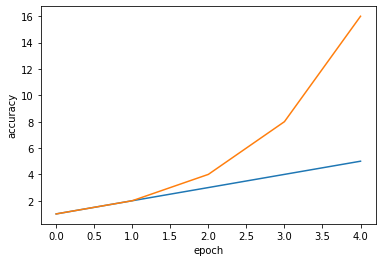

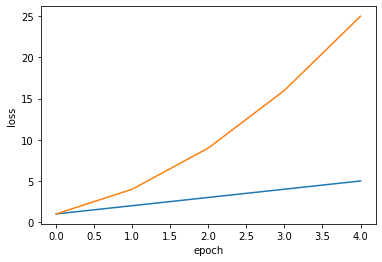

In [67]:
train_accuracy = [1, 2, 3, 4, 5]
test_accuracy = [1, 2, 4, 8, 16]
train_loss = [1, 2, 3, 4, 5]
test_loss = [1, 4, 9, 16, 25]

plt.figure()
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("accuracy.png", dpi=600)
plt.show()

plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("loss.png", dpi=600)
plt.show()

In [58]:
pep = "-41.312KYSDASDC+57.02HGEDSQAFC+57.02EK41"
rex = r"([A-Z]?)([-+]?\d*\.\d+|\d+)([A-Z]?)"
A = re.findall(rex, pep)
for a in A:
    print(a)
    if not a[0]:
        print("N terminal mod")
    elif not a[2]:
        print("C terminal mod")
    else:
        print("Internal mod")

('', '-41.312', 'K')
N terminal mod
('C', '+57.02', 'H')
Internal mod
('C', '+57.02', 'E')
Internal mod
('K', '41', '')
C terminal mod


In [109]:
pep = "KYSDASDCHGEDSQAFCEK"
rex = r"([A-Z]?)([-+]?\d*\.\d+|\d+)([A-Z]?)"
A = re.findall(rex, pep)
for a in A:
    print(a)
    if not a[0]:
        print("N terminal mod")
    elif not a[2]:
        print("C terminal mod")
    else:
        print("Internal mod")
pep = re.sub(r"[()]", "", pep)
print(pep)

KYSDASDCHGEDSQAFCEK


In [104]:
dic = {-1.9:"hello", 2.5:"Hi"}
print(dic)

{-1.9: 'hello', 2.5: 'Hi'}


In [107]:
num = '-41.318'
num = round(float(num), 2)
print(num)

-41.32


In [14]:
pep = "aBCDeFGJiGKl"
if pep[0].islower():
    pep = pep[1] + pep[0] + pep[2:]
print(pep)

BaCDeFGJiGKl
